# RSP Mix
The goal of this notebook is to examine mixtures of outputs from the r, s, and p processes and, if desired, compare them to cosmochemical data.

Begin by installing and importing the necessary python libraries

In [1]:
import sys, subprocess, importlib.metadata

required = {'requests', 'numpy', 'matplotlib', 'ipywidgets','wnutils', 'xmlcoll', 'scipy'}
installed = {x.name for x in importlib.metadata.distributions()}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import io, requests
from ipywidgets import interact, interactive_output, HBox
import ipywidgets as widgets
import matplotlib.pyplot as plt
import wnutils.xml as wx
import xmlcoll.coll as xc
import numpy as np
from scipy.optimize import curve_fit

# Preliminaries.

Define some routines for the notebook.  First, define a routine to retrieve zone abundances from the xml data.

In [2]:
def get_process_abundances(my_collection, compilation):
    proc = {}
    for process in ['p', 's', 'r']:
        proc[process] = {}
    for item in my_collection.get().values():
        solar_abundance = float(item.get_properties()['solar abundance'])
        for key, value in item.get_properties().items():
            if isinstance(key, tuple) and key[0] == compilation and key[1] == 'fraction':
                proc[key[2]][item.get_name()] = float(value) * solar_abundance
    return proc

Define a routine to retrieve the data for the processes and store in arrays.

In [3]:
def get_proc(sp, norm_species):

    y = []

    proc = {}
    for key in result:
        proc[key] = np.zeros(len(sp))
        count = 0
        for s in sp:
            if s in result[key]:
                proc[key][count] = result[key][s]
            count += 1
            
    for key in result:
        proc[key] /= (np.sum(proc[key]) + 1.e-300) # Add a small amount to denominator in case contribution is zero.
    
    return proc

Define a routine to retrieve mass numbers from a list of species.

In [4]:
def get_mass_numbers(nucs, sp):
    a = np.empty([0])
    for species in sp:
        a = np.append(a, nucs[species]['a'])
    return a

Define a routine to retrieve the element name from a species.

In [5]:
def get_element_string(norm_species):
    result = ""
    for char in norm_species:
        if char.isalpha():
            result += char
        
    return result.capitalize()

Define a routine to get the appropriate string for a species versus the normalizing species.

In [6]:
def get_sp_string(xml, nucs, sp, norm_species):
    return '^{i}\\rm{' + get_element_string(norm_species) + '} / ' + xml.get_latex_names(sp)[norm_species].strip('$')

Finally, define a mass-fractionation-correction routine that corrects the raw anomalies for instrumental or other fractionation.  The input should be the raw anomalies (*mu*) and the return should be the corrected anomalies (*mu_corr*).  The result should be that the anomaly in the correction species relative to the normalization species is zero.

The default is to assume that the mass fraction of species $i$ in a sample relative to that of species $j$ in a standard should be corrected for mass fractionation by an exponential law.  Thus, $\left(\frac{X_i}{X_j}\right)_{true} = \left(\frac{X_i}{X_j}\right)_{meas} \times \left(\frac{M_i}{M_j}\right)^{-\beta}$, where $true$ indicates the true ratio in the sample and $meas$ the measured ratio.  Since, to good approximation $M_i \propto A_i$, where $A_i$ is the mass number of species $i$, one can write $\left(\frac{X_i}{X_j}\right)_{true} = \left(\frac{X_i}{X_j}\right)_{meas} \times \left(\frac{A_i}{A_j}\right)^{-\beta}$.

To find the value of $\beta$, it is then assumed that the true ratio for the correction species $k$ relative to species $j$ should be the standard ($std$) value.  The standard value in this notebook is the Solar ratio, as read in from the appropriate file in a cell below.  Thus, once corrected for fractionation, species $k$ will have an anomaly of zero.  This yields $\beta = \ln\left\{\frac{(X_k / X_j)_{meas}}{(X_k/X_j)_{std}}\right\} / \ln(A_k / A_j)$.  Because the measured or raw $\mu_{ij} = 10^6 \left\{\frac{(X_i / X_j)_{meas}}{(X_i/X_j)_{std}} - 1\right\}$, then $\frac{(X_i / X_j)_{meas}}{(X_i/X_j)_{std}} = 1 + \frac{\mu_{ij}}{10^6}$.  One then finds $\beta = \ln\left(1 + \frac{\mu_{kj}}{10^6}\right) / \ln(A_k / A_j)$.  With $\beta$ now available, the corrected anomaly for species $i$ relative to $j$ is $\mu_{ij, corr} = 10^6 \left\{\frac{(X_i/X_j)_{true}}{(X_i/X_j)_{std}} - 1\right\} = 10^6 \left\{\frac{(X_i/X_j)_{meas}}{(X_i/X_j)_{std}} \left(\frac{A_i}{A_j}\right)^{-\beta} - 1\right\}$.  This may then be written $\mu_{ij, corr} = 10^6 \left\{\left(1 + \frac{\mu_{ij}}{10^6}\right)\left(\frac{A_i}{A_j}\right)^{-\beta} - 1\right\}$. The mass-fractionation correction routine thus takes in an array of raw anomalies $\mu$ (whose elements are $\mu_{ij}$), the normalization species $j$, and the correction species $k$.  It returns the corrected anomalies array $\mu_{corr}$ (whose elements are $\mu_{ij, corr}$).

In [7]:
def mass_fractionation_correction(mu, j, k):
    beta = np.log(1 + mu[k]/1.e6) / np.log(a[k] / a[j])
    mu_corr = 1.e6 * ((1 + mu / 1.e6) * np.power(a / a[j], -beta) - 1)
    return mu_corr

# Retrieve data.

Begin by reading in network data from [OSF](https://osf.io/kjnct/).  Retrieve the nuclides.

In [8]:
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
nucs = xml.get_nuclide_data()

Next, read in the nucleosynthesis processes data and store in a wnutils XML object.  The default is to use files downloaded from [OSF](https://osf.io/967yw/).  To use your own data, put them in your working directory or uploading to Colab or Binder.  Then comment the second line, uncomment the third line, and replace *example.xml* with the chosen name.

In [9]:
rsp = xc.Collection()
rsp.update_from_xml(io.BytesIO(requests.get('https://osf.io/z5wks/download').content))
#rsp.update_from_xml('example.xml')

Retrieve the data for the processes.  Begin by choosing the compilation.  The possible choices are '[prantzos](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.1832P/abstract)',  '[sneden](https://ui.adsabs.harvard.edu/abs/2008ARA%26A..46..241S/abstract)', '[goriely](https://ui.adsabs.harvard.edu/abs/1999A%26A...342..881G/abstract)', or '[bisterzo](https://ui.adsabs.harvard.edu/abs/2014ApJ...787...10B/abstract)'.  Note that the Bisterzo table only includes contribution from the main s process; thus, for the present table, the r-process contribution is computed as the solar contribution less that main s-process contribution.  As a consequence, the compilation based on Bisterzo overestimates the r-process contribution for elements with a weak s-process contribution.  For elements with atomic number less than about 45, it is preferable not to use 'bisterzo' in this notebook

In [10]:
compilation = 'prantzos'

Now get the data.

In [11]:
result = get_process_abundances(rsp, compilation)

# Study nucleosynthesis mixtures.

Specify the species of interest, the normalizing species, and the mass-fractionation correction species.  Examples for species from different elements are available at [OSF](https://osf.io/mws8q).  You can cut and paste directly from that site, if appropriate.

In [12]:
sp = np.array(['mo92', 'mo94', 'mo95', 'mo96', 'mo97', 'mo98', 'mo100'])
norm_species = 'mo96'
corr_species = 'mo98'

Check that the normalizing and mass-fractionation-correction species are present.  Retrieve mass numbers and strings.

In [13]:
assert norm_species in sp, "Normalizing species not in species list"
assert corr_species in sp, "Mass-fractionation-correction species not in species list"

a = get_mass_numbers(nucs, sp)
element_string = get_element_string(norm_species) 
sp_string = get_sp_string(xml, nucs, sp, norm_species)

Get the process data for the species.  Set the normalization index and mass-fractionation correction species index

In [14]:
proc = get_proc(sp, norm_species)
i_norm = np.where(sp == norm_species)
i_corr = np.where(sp == corr_species)

In [15]:
a = get_mass_numbers(nucs, sp)

Plot the process contributions.

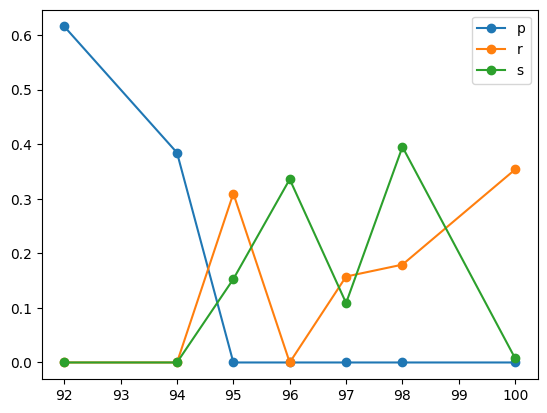

In [16]:
for key in ['p', 'r', 's']:
    plt.plot(a, proc[key], 'o-', label = key)
    
plt.legend()

Get the standard abundance ratios.  By default, these are loaded from the processes data file.  To include your own data, uncomment and populate the last line in the following cell.

In [17]:
y = {}
for item in rsp.get().values():
    y[item.get_name()] = float(item.get_properties()['solar abundance'])

standard = []

for s in sp:
    standard = np.append(standard, y[s] / y[norm_species])
    
#standard = np.array([])  # To use your own standard data, uncomment and populate this array.

Define a fit function for the processes to the standard abundances.

In [18]:
def fit_function(x, a_p, a_r, a_s):
    result = a_p * proc['p'] + a_r * proc['r'] + a_s * proc['s']
    result /= result[i_norm]
    return result

Compute the best fit to the standard.  Normalize the fit parameters.

In [19]:
popt_std, pcov_std = curve_fit(fit_function, a, standard, bounds=(0, [1, 1, 1]))
popt_std /= np.sum(popt_std)

Plot the fit.

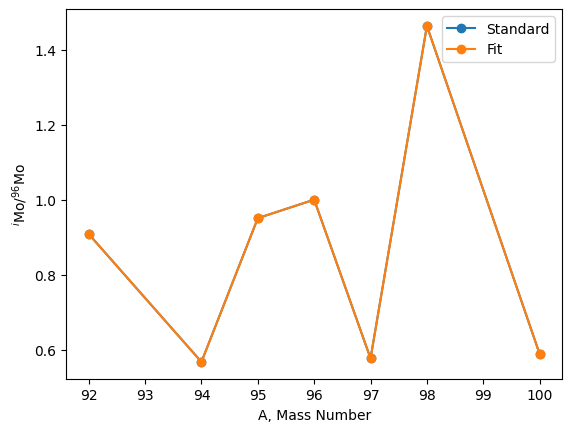

In [20]:
plt.plot(a, standard, '-o', label='Standard')

plt.plot(a, fit_function(a, *popt_std), '-o', label='Fit')

plt.xlabel('A, Mass Number')
plt.ylabel('$' + sp_string + '$')
plt.legend()

With the fit of nucleosynthetic components available, compute and print out the process contributions for each species.  The number in parentheses gives the abundance of the species relative to the normalizing speices in the fit.

In [21]:
c_hash = {'p': 0, 'r': 1, 's': 2}

y_fit = {}
y_sum = np.zeros(len(a))
for key in c_hash:
    y_fit[key] = popt_std[c_hash[key]] * proc[key]
    y_sum += y_fit[key]
    
contribs = {}
    
for key in y_fit:
    contribs[key] = 100. * y_fit[key] / y_sum 
    
for i in range(len(sp)):
    print('{:s} ({:.2f}% of {:s})'.format(sp[i], 100 * y_sum[i] / np.sum(y_sum), element_string))
    for key in contribs:
        print('    {:s}: {:.2f}%'.format(key, contribs[key][i]))
    print("")

mo92 (15.00% of Mo)
    p: 100.00%
    r: 0.00%
    s: 0.00%

mo94 (9.37% of Mo)
    p: 100.00%
    r: 0.00%
    s: 0.00%

mo95 (15.70% of Mo)
    p: 0.00%
    r: 52.10%
    s: 47.90%

mo96 (16.52% of Mo)
    p: 0.00%
    r: 0.00%
    s: 100.00%

mo97 (9.52% of Mo)
    p: 0.00%
    r: 43.70%
    s: 56.30%

mo98 (24.17% of Mo)
    p: 0.00%
    r: 19.60%
    s: 80.40%

mo100 (9.72% of Mo)
    p: 0.00%
    r: 96.20%
    s: 3.80%



Now graphically represent the process contributions to each species.

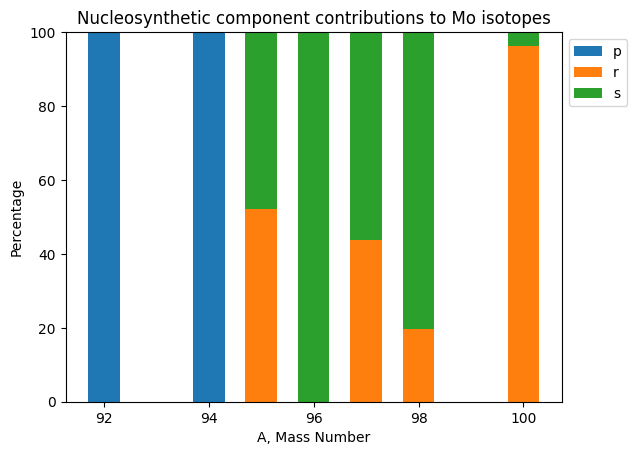

In [22]:
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(len(a))

for key, contrib in contribs.items():
    p = ax.bar(a, contrib, width, label=key, bottom=bottom)
    bottom += contrib
    
ax.set_xlabel('A, Mass Number')
ax.set_ylabel('Percentage')
    
ax.set_title('Nucleosynthetic component contributions to {:s} isotopes'.format(element_string))
ax.legend(bbox_to_anchor = (1,1), loc='upper left', ncol = 1)

plt.show()

With appropriate nucleosynthetic contributions now available, you can practice adding and subtracting different mixes of those components (in parts per million). Set *rng* to define the maximum range of variation of the components. Use the float text boxes to adjust the contribution of each component. You can enter values directly or click on the up/down arrows to increase or decrease the contribution.  Note that p_proc is the p-process component, r_proc is the r-process component, and s_proc is the s-process component.  Click on the *Show raw pattern* button to plot the pattern before the mass-fractionation correction.

The anomalies are computed from the mass fractions in a sample taken to arise from a particular mix of mass drawn from the $r$-, $s$-, and $p$-process reservoirs.  The standard has a fraction $f_r$ of its mass from the $r$-process reservoir, a fraction $f_s$ of its mass from the $s$-process reservoir, and a fraction $f_p$ of its mass from the $p$-process reservoir.  The resulting mass fraction of species $i$ for the standard is thus $X_i^{standard} = f_r X_i^{(r)} + f_s X_i^{(s)} + f_p X_i^{(p)}$, where $X_i^{(q)}$ is the mass fraction of species $i$ in reservoir $q = r, s, p$.  In a sample arising from a different mix of $r$-, $s$-, and $p$-process contributions, the resulting mass fraction of species $i$ will be $X_i^{sample} = {\cal N}^{-1} \left[f_r \left(1 + \frac{\delta f_r}{f_r}\right) X_i^{(r)} + f_s \left(1 + \frac{\delta f_s}{f_s}\right) X_i^{(s)} + f_p \left(1 + \frac{\delta f_p}{f_p}\right) X_i^{(p)}\right]$, where $\delta f_q = f_q^{sample} - f_q$ for each reservoir $q$ and ${\cal N} = 1 + \delta f_r + \delta f_s + \delta f_p$.  Since ${\cal N}$ cancels out in the calculation of relative anomalies, anomalies in samples may be computed by varying $\delta f_q / f_q$ for $q = r, s, p$, as done here (in units of parts per million).

In [23]:
rng = 1000

def f(p_proc, r_proc, s_proc, b_corr):
    c_p = (1 + p_proc/1.e6) * popt_std[0]
    c_r = (1 + r_proc/1.e6) * popt_std[1]
    c_s = (1 + s_proc/1.e6) * popt_std[2]

    reference = fit_function(a, *popt_std)
    reference /= reference[i_norm]
    result = c_p * proc['p'] + c_r * proc['r'] + c_s * proc['s']
    result /= result[i_norm]
    mu_raw = 1.e6 * (result / reference - 1)
    
    mu = mass_fractionation_correction(mu_raw, i_norm, i_corr)
    
    plt.plot(a, mu, '-o', label='corrected')
    
    if b_corr:
        plt.plot(a, mu_raw, ':o', label='raw')

    plt.xlabel('A, Mass Number')
    plt.ylabel('$\\mu(' + sp_string + ')$')
    
    if b_corr:
        plt.legend()
        
    plt.show()
        
interact(f, p_proc = widgets.BoundedFloatText(value=0, min=-rng, max = rng, step=0.01, 
                                              descriptions='p_proc:', disabled=False),
            r_proc = widgets.BoundedFloatText(value=0, min=-rng, max = rng, step=0.01, 
                                              descriptions='r_proc:', disabled=False),
            s_proc = widgets.BoundedFloatText(value=0, min=-rng, max = rng, step=0.01, 
                                              descriptions='s_proc:', disabled=False),
            b_corr = widgets.Checkbox(value=False, description='Show raw pattern', disabled=False, 
                                      indent=True))

interactive(children=(BoundedFloatText(value=0.0, description='p_proc', max=1000.0, min=-1000.0, step=0.01), B…

<function __main__.f(p_proc, r_proc, s_proc, b_corr)>

# Compare to data.

This section allows the user to compare nucleosynthetic mixtures to data. The default is not to run the comparison (*run_comparison = False*).  To make the comparison, set *run_comparison* to *True*.

In [24]:
run_comparison = False

Add data and error values to compare to nucleosynthetic mixes.  Make sure that no error value is zero as this will cause a problem with the fits.  The *data* array gives the deviations from the standard for each species (in parts per million) while *error* is the array giving the uncertainty for each data point.  The *data* and *error* arrays need to match up with the *a* and *sp* arrays defined above.  The example data are for the Chihuahua City IC iron meteorite from [Kruijer et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017PNAS..114.6712K/abstract).  Other example data are available at [OSF](https://osf.io/xs5b2/wiki/home/).

In [25]:
data = np.array([96, 86, 34, 0, 20, 0, 27])   # Mo anomalies from Chihuahua City
error = np.array([12, 8, 7, 0.1, 8, 0.1, 13])   # Mo anomalies from Chihuahua City

Check for zero error values.

In [26]:
if run_comparison:
    assert np.all(error), "An error value is zero."

Define a fit function for the anomaly data.

In [27]:
if run_comparison:
    def fit_function2(x, a_p, a_r, a_s):
        result = a_p * proc['p'] + a_r * proc['r'] + a_s * proc['s']
        result /= result[i_norm]    
        reference = fit_function(x, *popt_std)
        mu_raw = 1.e6 * ((result / reference) - 1)
        mu = mass_fractionation_correction(mu_raw, i_norm, i_corr)
        return mu

Fit the data.  Normalize the fit parameters.

In [28]:
if run_comparison:
    popt_mu, pcov_mu = curve_fit(fit_function2, a, data, bounds=(0, [1, 1, 1]), sigma=error)
    popt_mu /= np.sum(popt_mu)

Print the fit parameters.

In [29]:
if run_comparison:
    a_fit = 1.e6 * (popt_mu/np.sum(popt_mu)/(popt_std/np.sum(popt_std)) - 1)

    print('p_proc: {:.2f}'.format(a_fit[0]))
    print('r_proc: {:.2f}'.format(a_fit[1]))
    print('s_proc: {:.2f}'.format(a_fit[2]))

Add and subtract nucleosynthetic components (in parts per million) to fit the data. Use the float text boxes to adjust the contribution of each component. You can enter values directly or click on the up/down arrows to increase or decrease the contribution. Note that p_proc is the p-process component, r_proc is the r-process component, and s_proc is the s-process component.  Click on the *Print fit mu values* to show the numerical values of the fitted mus or *Show raw pattern* button to plot the pattern before the mass-fractionation correction.

The plot starts with the best fit parameters from the cell above.

In [30]:
if run_comparison:
    def f(p_proc, r_proc, s_proc, b_corr, b_print):
        c_p = (1 + p_proc/1.e6) * popt_std[0]
        c_r = (1 + r_proc/1.e6) * popt_std[1]
        c_s = (1 + s_proc/1.e6) * popt_std[2]

        reference = fit_function(a, *popt_std)
        reference /= reference[i_norm]
        result = c_p * proc['p'] + c_r * proc['r'] + c_s * proc['s']
        result /= result[i_norm]
        mu_raw = 1.e6 * (result / reference - 1)
        
        mu = mass_fractionation_correction(mu_raw, i_norm, i_corr)

        plt.plot(a, mu, '-o', label='corrected fit')
        plt.errorbar(a, data, fmt='-o', yerr=error, label='data')
        
        if b_corr:
            plt.plot(a, mu_raw, ':o', label='raw fit')

        if b_print:
            print(f"Fit values:\n")
            for i in range(len(a)):
                print(f"A = {int(a[i]):d}, mu = {mu[i]:.2f}")

        plt.xlabel('A, Mass Number')
        plt.ylabel('$\\mu(' + sp_string + ')$')
        plt.legend()
        
        plt.show()

    a_f = [round(x, 0) for x in a_fit]

    p_proc = widgets.BoundedFloatText(value=a_f[0], min=-1.e6, max=1.e20,
                                      step=1, descriptions='p_proc:', disabled=False)
    r_proc = widgets.BoundedFloatText(value=a_f[1], min=-1.e6, max=1.e20,
                                      step=1, descriptions='r_proc:', disabled=False)
    s_proc = widgets.BoundedFloatText(value=a_f[2], min=-1.e6, max=1.e20,
                                      step=1, descriptions='s_proc:', disabled=False)
    b_corr = widgets.Checkbox(value=False, description='Show raw pattern',
                                      disabled=False, indent=False)
    b_print = widgets.Checkbox(value=False, description='Print fit mu values',
                                      disabled=False, indent=False)

    out = interactive_output(f, {'p_proc': p_proc, 'r_proc': r_proc, 's_proc': s_proc,
                                 'b_corr': b_corr, 'b_print': b_print})
    display(HBox([p_proc]), HBox([r_proc]), HBox([s_proc]), HBox([b_print, b_corr]), out)